In [1]:
from math import pi
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt

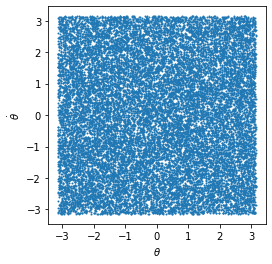

In [2]:
# The first step in learning a neural certificate is to define the dynamics and build a dataset.

# Let's define the dynamics in closed-loop form for now (potentially revisit control-affine later)
n_states = 2
n_controls = 1
def dynamics_fn(x, u):
    """Inverted pendulum dynamics"""
    theta = x[:, 0]
    theta_dot = x[:, 1]
    input_torque = u[:, 0]
    
    mass = 0.15
    damping = 0.1
    length = 0.5
    inertia = mass * length ** 2
    g = 9.81

    acceleration = g / length * torch.sin(theta)
    acceleration += input_torque / inertia
    acceleration -= damping * theta_dot / inertia
    
    xdot = torch.zeros_like(x)
    xdot[:, 0] = theta_dot
    xdot[:, 1] = acceleration
    
    return xdot

# We can build a dataset in the simplest possible way by randomly sampling a bunch of points
n_train = int(2e4)
x_train = torch.Tensor(n_train, n_states).uniform_(-pi, pi)  # theta and theta_dot in [-pi, pi]

# We can plot the dataset to make sure we have good coverage (this is less helpful in higher dimensions)
plt.scatter(x_train[:, 0], x_train[:, 1], s=1.0)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot{\theta}$")
plt.gca().set_aspect("equal")

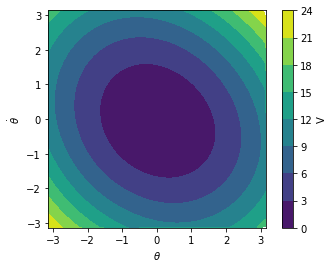

In [3]:
# Now we need to learn both a controller and a Lyapunov function
# You could also learn a CLF and derive the controller using a QP,
# but that involves a bit more plumbing that I'll add later.

# Let's assume that the goal point is x = 0

# Let's define both of these as neural networks. Since the Lyapunov function is
# roughly quadratic, it helps to give it a roughly quadratic form.
class LyapNN(torch.nn.Module):
    def __init__(
        self,
        hidden_layers: int,
        hidden_layer_width: int,
        n_states: int,
    ):
        """
        A model for learning a Lyapunov function.
        
        We'll learn the Lyapunov function as
        
        V(x) = x.T * P.T * P * x + v.T * v
        
        where P is a matrix with trainable parameters and v is the output of a neural network

        args:
            hidden_layers: how many hidden layers to have
            hidden_layer_width: how many neurons per hidden layer
            n_states: how many input state dimensions
        """
        super(LyapNN, self).__init__()


        # Construct the network
        self.layers = OrderedDict()
        self.layers["input_linear"] = nn.Linear(
            n_states,
            hidden_layer_width,
        )
        for i in range(hidden_layers):
            self.layers[f"layer_{i}_activation"] = nn.Tanh()
            self.layers[f"layer_{i}_linear"] = nn.Linear(
                hidden_layer_width, hidden_layer_width
            )
        self.nn = nn.Sequential(self.layers)
        
        # Also make some trainable parameters for the P matrix
        self.P = torch.nn.Parameter(torch.tensor([[1.0, 0.1], [0.1, 1.0]]))

    def forward(self, x: torch.Tensor):
        v = self.nn(x)  # batch size x hidden_layer_width
        vv = (v * v).sum(dim=-1) # batch_size x 1
        PP = self.P.T @ self.P  # n_states x n_states
        xPx = F.bilinear(x, x, PP.reshape(1, n_states, n_states))  # batch_size x 1
        return xPx.squeeze() + vv
    
# Make the Lyapunov network
lyap_nn = LyapNN(2, 8, n_states)

# This will be randomly initialized, but we can still plot it!
with torch.no_grad():  # no gradient needed for plotting
    plt.tricontourf(x_train[:, 0], x_train[:, 1], lyap_nn(x_train))
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$\dot{\theta}$")
    plt.colorbar(label="V")
    plt.gca().set_aspect("equal")

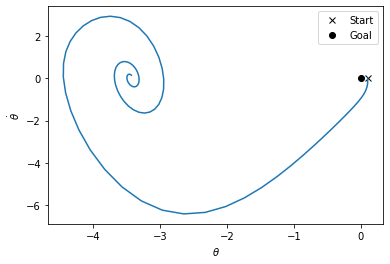

In [4]:
# Now we can define a policy network in a similar way
class ControlNN(torch.nn.Module):
    def __init__(
        self,
        hidden_layers: int,
        hidden_layer_width: int,
        n_states: int,
        n_controls: int,
    ):
        """
        A model for learning a control policy.

        args:
            hidden_layers: how many hidden layers to have
            hidden_layer_width: how many neurons per hidden layer
            n_states: how many input state dimensions
            n_controls: how many output control dimensions
        """
        super(ControlNN, self).__init__()


        # Construct the network
        self.layers = OrderedDict()
        self.layers["input_linear"] = nn.Linear(
            n_states,
            hidden_layer_width,
        )
        self.layers["input_activation"] = nn.Tanh()
        for i in range(hidden_layers):
            self.layers[f"layer_{i}_linear"] = nn.Linear(
                hidden_layer_width, hidden_layer_width
            )
            self.layers[f"layer_{i}_activation"] = nn.Tanh()
        self.layers["output_linear"] = nn.Linear(
            hidden_layer_width, n_controls
        )
        self.layers[f"output_activation"] = nn.Tanh()
        self.nn = nn.Sequential(self.layers)

    def forward(self, x: torch.Tensor):
        u = self.nn(x)  # batch size x n_controls
        return u

# Make the control network
control_nn = ControlNN(2, 8, n_states, n_controls)

# This will be randomly initialized, and so it will likely not contol the system very well,
# but that won't stop us from trying!
with torch.no_grad():  # no gradient needed for simulation/plotting
    dt = 0.05
    n_steps = 100
    x_sim = torch.zeros((n_steps, n_states))
    x_sim[0, :] = torch.tensor([0.1, 0.0])
    for tstep in range(1, n_steps):
        x_current = x_sim[tstep - 1, :].reshape(1, n_states)
        u = control_nn(x_current)
        xdot = dynamics_fn(x_current, u)
        x_sim[tstep, :] = x_current + dt * xdot

    plt.plot(x_sim[0, 0], x_sim[0, 1], "kx", label="Start")
    plt.plot(0, 0, "ko", label="Goal")
    plt.plot(x_sim[:, 0], x_sim[:, 1])
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$\dot{\theta}$")
    plt.legend()

In [5]:
# Not great, but we can do better!

# The next step is to define the loss that let's us refine our lyapunov function and
# controller to be stable.

def lyapunov_loss(x, u):
    loss = torch.tensor(0.0)
    
    # The lyapunov function should be zero close to the goal
    x_goal = torch.zeros((1, 2))
    loss += (lyap_nn(x_goal) ** 2).squeeze()
    
    # The lyapunov function should have negative derivative.
    
    # We can try to get the exact derivative, but this can be unreliable
    # V = lyap_nn(x)
    # grad_V = jacobian(lambda x: lyap_nn(x).sum(), x, create_graph=True)  # create_graph lets us backpropagate
    # xdot = dynamics_fn(x, u)
    # dV_dt = torch.bmm(grad_V.reshape(-1, 1, n_states), xdot.reshape(-1, n_states, 1))

    # Use a numerical approximation instead
    V_now = lyap_nn(x)
    dt = 0.01
    x_next = x + dt * dynamics_fn(x, u)
    V_next = lyap_nn(x_next)
    dV_dt = (V_next - V_now) / dt
    
    lyapunov_lambda = 1.0  # decrease this fast
    margin = 0.1  # be at least this negative
    loss += F.relu(margin + dV_dt + lyapunov_lambda * V_now).mean()
    
    return loss
    
# Now we can do training!
learning_rate = 1e-4
optimizer = torch.optim.Adam(
    list(lyap_nn.parameters()) + list(control_nn.parameters()),
    lr=learning_rate
)

n_epochs = 200  # run through the dataset this many times
batch_size = 512  # how many points to evaluate at a time
for epoch in range(n_epochs):
    permutation = torch.randperm(n_train)

    loss_accumulated = 0.0
    epoch_range = range(0, n_train, batch_size)
    for i in epoch_range:
        batch_indices = permutation[i : i + batch_size]
        x_batch = x_train[batch_indices]

        # Forward pass: predict the control input and get the lyapunov loss
        u = control_nn(x_batch)
        loss = lyapunov_loss(x_batch, u)

        # Compute backpropagate and step the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the loss for logging
        loss_accumulated += loss.detach()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Lyapunov loss {loss_accumulated / (n_train / batch_size)}")

Epoch 0: Lyapunov loss 22.736207962036133
Epoch 10: Lyapunov loss 8.958108901977539
Epoch 20: Lyapunov loss 1.8675537109375
Epoch 30: Lyapunov loss 1.0610779523849487
Epoch 40: Lyapunov loss 0.7521140575408936
Epoch 50: Lyapunov loss 0.5767691135406494
Epoch 60: Lyapunov loss 0.4412101209163666
Epoch 70: Lyapunov loss 0.35785365104675293
Epoch 80: Lyapunov loss 0.29004937410354614
Epoch 90: Lyapunov loss 0.22502362728118896
Epoch 100: Lyapunov loss 0.17199595272541046
Epoch 110: Lyapunov loss 0.1239389032125473
Epoch 120: Lyapunov loss 0.0870097205042839
Epoch 130: Lyapunov loss 0.06146232411265373
Epoch 140: Lyapunov loss 0.04086948186159134
Epoch 150: Lyapunov loss 0.024936651811003685
Epoch 160: Lyapunov loss 0.014799868687987328
Epoch 170: Lyapunov loss 0.01053264457732439
Epoch 180: Lyapunov loss 0.0069259582087397575
Epoch 190: Lyapunov loss 0.0036459704861044884


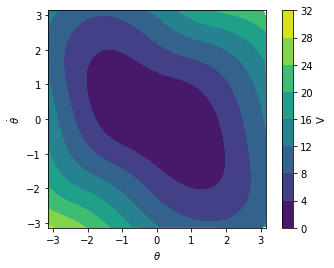

In [6]:
# That loss should be decreasing! Let's see what the Lyapunov function looks like!
with torch.no_grad():  # no gradient needed for plotting
    plt.tricontourf(x_train[:, 0], x_train[:, 1], lyap_nn(x_train))
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$\dot{\theta}$")
    plt.colorbar(label="V")
    plt.gca().set_aspect("equal")

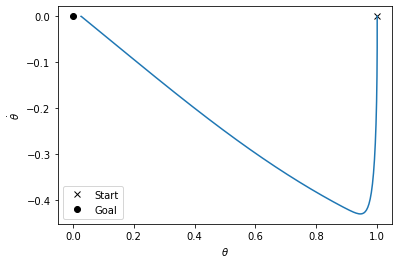

In [7]:
# Does the controller work?
with torch.no_grad():  # no gradient needed for simulation/plotting
    dt = 0.01
    n_steps = 5000
    x_sim = torch.zeros((n_steps, n_states))
    x_sim[0, :] = torch.tensor([1.0, 0.0])
    for tstep in range(1, n_steps):
        x_current = x_sim[tstep - 1, :].reshape(1, n_states)
        u = control_nn(x_current)
        xdot = dynamics_fn(x_current, u)
        x_sim[tstep, :] = x_current + dt * xdot

    plt.plot(x_sim[0, 0], x_sim[0, 1], "kx", label="Start")
    plt.plot(0, 0, "ko", label="Goal")
    plt.plot(x_sim[:, 0], x_sim[:, 1])
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$\dot{\theta}$")
    plt.legend()

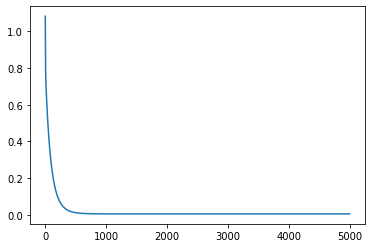

In [8]:
with torch.no_grad():
    plt.plot(lyap_nn(x_sim))

In [9]:
# Eyyyy it's not perfect but neither are any of us so...